# Multiclass Image detection: Electronics Components

## Overview

The purpose of this notebook is to analyze the data and make a multiclass image detection model to determine which electronic component is shown on the input image.

The training data is available in [kaggle](https://www.kaggle.com/datasets/olavomendes/elec-dataset)

It contains images labeled as one of the 5 classes we are interested in (led, potentiometer, push_button, resistor or ultrasonic sensor)


In [1]:
import tensorflow as tf
from tensorflow import keras
import time
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

import fnmatch, os
import numpy as np

2023-01-26 23:01:04.594670: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Let's start by analyzing how many images we have per label, per set (training, testing). We can do this by counting the number of files in each directory/label. In the process, we can also view a few samples of each, including the image size.

train_set-ultrasonic_sensor:149
train_set-potentiometer:150
train_set-push_button:150
train_set-resistor:150
train_set-led:150
test_set-ultrasonic_sensor:50
test_set-potentiometer:49
test_set-push_button:49
test_set-resistor:49
test_set-led:49


<Figure size 2200x2200 with 0 Axes>

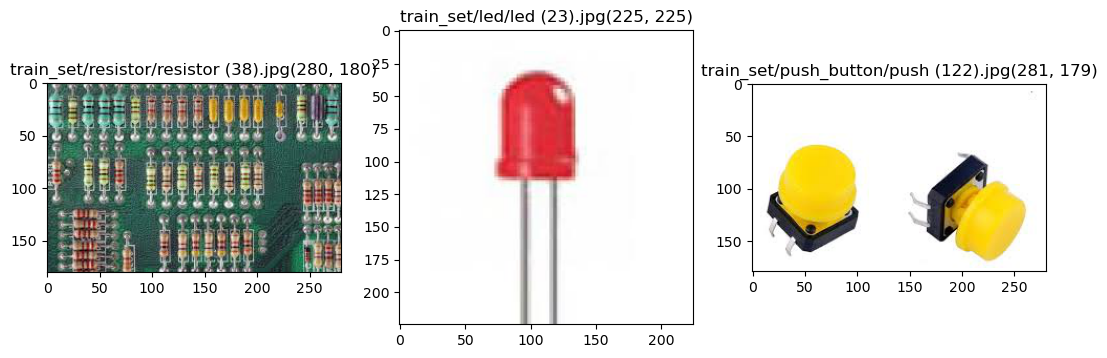

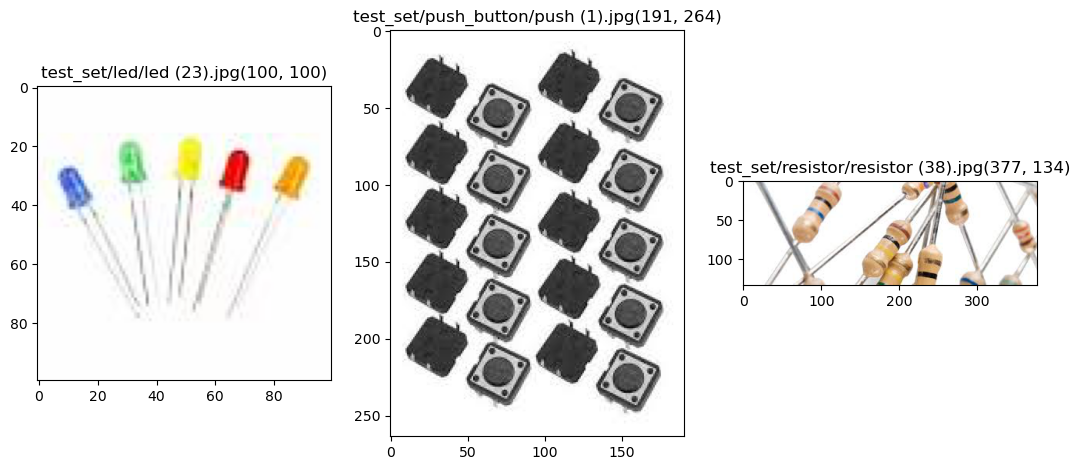

In [2]:
input_path = 'electronics_dataset/'

images_count={"train_set":{}, "test_set":{}}

samples=53
i=1
for (root,dirs,files) in os.walk(input_path, topdown=True):
    path=root.split("/");
    if len(path)<=2:
        plt.figure(figsize=(22,22))
    if len(path)>2:
        images_count[path[1]][path[2]]=len(files)
        print (path[1]+"-"+path[2]+":"+str(images_count[path[1]][path[2]]))
        # load the image
        image_filename=input_path+path[1]+"/"+path[2]+"/"+files[0]
        img = load_img(image_filename)
        plt.subplot(1,5,i)
        plt.imshow(img)
        plt.title(image_filename[len(input_path):] + str(img.size))
        i=i+1
        if i>3:
            i=1


We can see we have about 150 images for training for each category, and for testing we have approx 50 per each. 

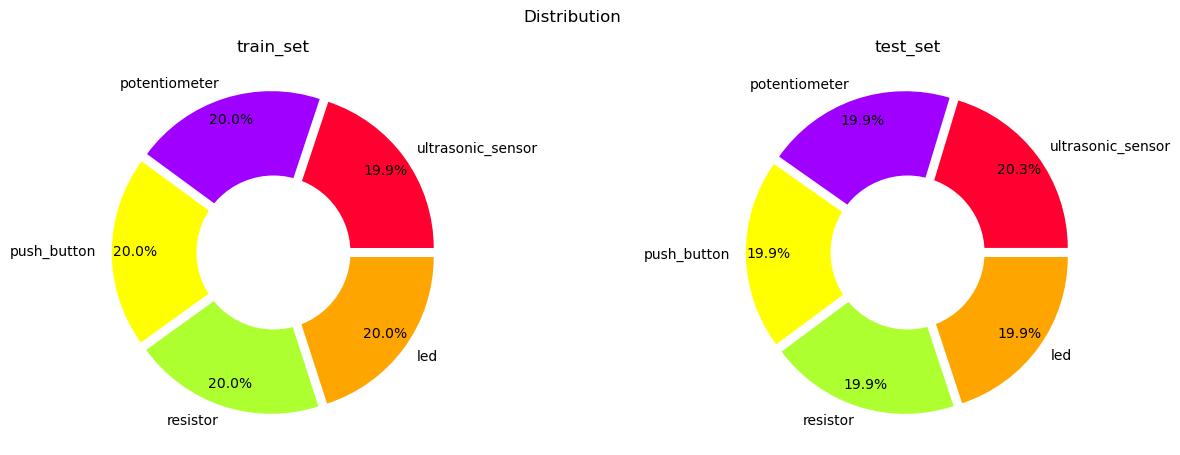

In [3]:
def draw_donut_chart(set_to_draw, pos):

    colors = ['#FF0030', '#A000FF', '#FFFF00', 
              '#ADFF2F', '#FFA500']
    explode = (0.05, 0.05, 0.05, 0.05, 0.05)

    plt.subplot(1, 2, pos)
    plt.pie(list(images_count[set_to_draw].values()), colors=colors, labels=list(images_count[set_to_draw].keys()),
            autopct='%1.1f%%', pctdistance=0.85,
            explode=explode)

    # draw circle
    centre_circle = plt.Circle((0, 0), 0.50, fc='white')
    fig = plt.gcf()

    # Adding Circle in Pie chart
    fig.gca().add_artist(centre_circle)

    # Adding Title of chart
    plt.title(set_to_draw)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Distribution')

draw_donut_chart ("train_set", 1)
draw_donut_chart ("test_set", 2)

We can see that the distribution is quite even for all categories and for both training and testing

Our dataset has already neatly separated training and validation samples. In the code below, we construct a Keras data object for the training and validation sets using `keras.preprocessing.flow_from_directory`. We chose the Adam optimizer and used different learning rates.  It learns from each image, updates the model gradients, and gradually improves its performance.

We will be doing transfer learning based off of the Xception model

In [4]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions


from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [5]:
image_size = (150, 150)
batch_size = 32
number_of_categories=5

In [6]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory(
    input_path+"train_set",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 749 images belonging to 5 classes.


In [7]:
validation_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = validation_gen.flow_from_directory(
    input_path+"test_set",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 246 images belonging to 5 classes.


In [8]:
def make_model(learning_rate):
    base_model = Xception(
        weights='imagenet',
        input_shape=(150, 150, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))

    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)
    
    # Adding one dense layer with 5 neurons, one per category
    
    outputs = keras.layers.Dense(number_of_categories)(vector)

    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    
    return model

In [9]:
learning_rate = 0.01
model = make_model(learning_rate=learning_rate)
history = model.fit(train_ds, epochs=10, validation_data=val_ds)


2023-01-26 23:01:08.137942: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 23:01:08.152266: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 23:01:08.152908: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 23:01:08.153825: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Epoch 1/10


2023-01-26 23:01:13.368148: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-01-26 23:01:14.001918: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-26 23:01:14.002855: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-26 23:01:14.002890: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-01-26 23:01:14.003861: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-26 23:01:14.003945: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


24/24 [==============================] - 8s 159ms/step - loss: 0.6545 - accuracy: 0.7984 - val_loss: 0.2950 - val_accuracy: 0.9065
Epoch 2/10
24/24 [==============================] - 2s 72ms/step - loss: 0.1115 - accuracy: 0.9640 - val_loss: 0.1672 - val_accuracy: 0.9390
Epoch 3/10
24/24 [==============================] - 2s 73ms/step - loss: 0.0288 - accuracy: 0.9893 - val_loss: 0.2999 - val_accuracy: 0.9146
Epoch 4/10
24/24 [==============================] - 2s 73ms/step - loss: 0.0114 - accuracy: 0.9973 - val_loss: 0.2459 - val_accuracy: 0.9187
Epoch 5/10
24/24 [==============================] - 2s 73ms/step - loss: 0.0060 - accuracy: 0.9987 - val_loss: 0.2928 - val_accuracy: 0.9146
Epoch 6/10
24/24 [==============================] - 2s 73ms/step - loss: 0.0054 - accuracy: 0.9987 - val_loss: 0.2283 - val_accuracy: 0.9268
Epoch 7/10
24/24 [==============================] - 2s 73ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.2419 - val_accuracy: 0.9268
Epoch 8/10
24/24 [=====

In [10]:
def plot_accuracy(which_history, version):

    plt.figure(figsize=(6, 4))

    epochs = which_history.epoch
    val = which_history.history['val_accuracy']
    train = which_history.history['accuracy']

    plt.plot(epochs, val, color='black', linestyle='solid', label='validation')
    plt.plot(epochs, train, color='black', linestyle='dashed', label='train')

    plt.title('Xception v1, lr='+str(learning_rate))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.xticks(np.arange(10))

    plt.legend()

    version_string=str(version).replace(".","_")
    filename="xception_v1_%s.svg" %version_string
    plt.savefig(filename)

    plt.show()

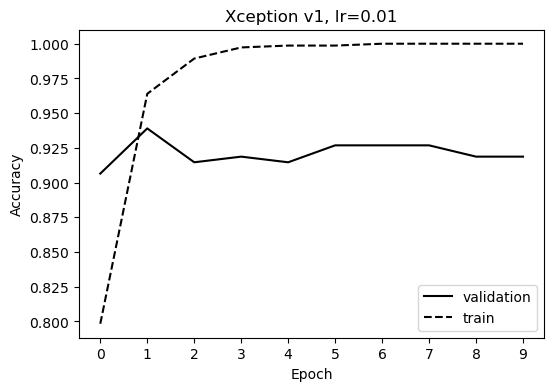

In [11]:
plot_accuracy (history, learning_rate)

In [12]:
learning_rate = 0.001
model = make_model(learning_rate=learning_rate)
history_0_001 = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
24/24 [==============================] - 5s 111ms/step - loss: 0.7994 - accuracy: 0.7370 - val_loss: 0.4232 - val_accuracy: 0.8780
Epoch 2/10
24/24 [==============================] - 2s 73ms/step - loss: 0.2509 - accuracy: 0.9439 - val_loss: 0.2969 - val_accuracy: 0.8984
Epoch 3/10
24/24 [==============================] - 2s 73ms/step - loss: 0.1702 - accuracy: 0.9640 - val_loss: 0.2361 - val_accuracy: 0.9187
Epoch 4/10
24/24 [==============================] - 2s 74ms/step - loss: 0.1285 - accuracy: 0.9760 - val_loss: 0.2451 - val_accuracy: 0.9024
Epoch 5/10
24/24 [==============================] - 2s 73ms/step - loss: 0.1010 - accuracy: 0.9800 - val_loss: 0.2311 - val_accuracy: 0.9024
Epoch 6/10
24/24 [==============================] - 2s 73ms/step - loss: 0.0809 - accuracy: 0.9920 - val_loss: 0.2058 - val_accuracy: 0.9106
Epoch 7/10
24/24 [==============================] - 2s 73ms/step - loss: 0.0674 - accuracy: 0.9933 - val_loss: 0.2006 - val_accuracy: 0.9187
Epoch 8/10
2

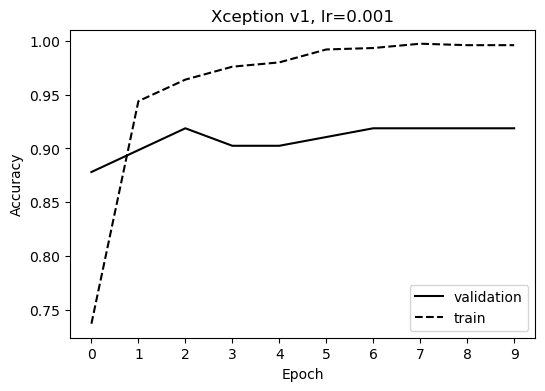

In [13]:
plot_accuracy (history_0_001, learning_rate)

In [14]:
learning_rate=0.0001
model = make_model(learning_rate=learning_rate)
history_0_0001 = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
24/24 [==============================] - 5s 107ms/step - loss: 1.5014 - accuracy: 0.3618 - val_loss: 1.3035 - val_accuracy: 0.4959
Epoch 2/10
24/24 [==============================] - 2s 73ms/step - loss: 1.1669 - accuracy: 0.5848 - val_loss: 1.0587 - val_accuracy: 0.6707
Epoch 3/10
24/24 [==============================] - 2s 73ms/step - loss: 0.9436 - accuracy: 0.7036 - val_loss: 0.8890 - val_accuracy: 0.7480
Epoch 4/10
24/24 [==============================] - 2s 73ms/step - loss: 0.7844 - accuracy: 0.7864 - val_loss: 0.7716 - val_accuracy: 0.7927
Epoch 5/10
24/24 [==============================] - 2s 73ms/step - loss: 0.6735 - accuracy: 0.8371 - val_loss: 0.6810 - val_accuracy: 0.8171
Epoch 6/10
24/24 [==============================] - 2s 73ms/step - loss: 0.5869 - accuracy: 0.8745 - val_loss: 0.6160 - val_accuracy: 0.8333
Epoch 7/10
24/24 [==============================] - 2s 73ms/step - loss: 0.5230 - accuracy: 0.8892 - val_loss: 0.5648 - val_accuracy: 0.8618
Epoch 8/10
2

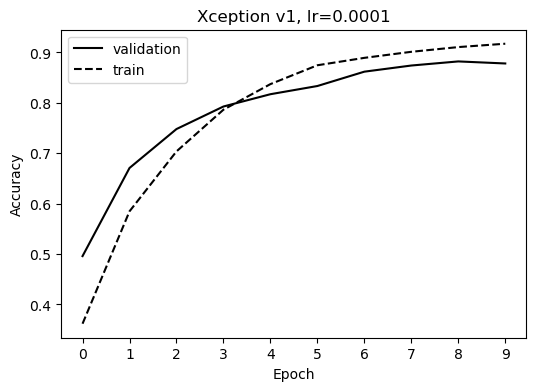

In [15]:
plot_accuracy (history_0_0001, learning_rate)

In [16]:
epochs = np.arange(10)
val_0_01 = history.history['val_accuracy']
val_0_001 = history_0_001.history['val_accuracy']
val_0_0001 = history_0_0001.history['val_accuracy']

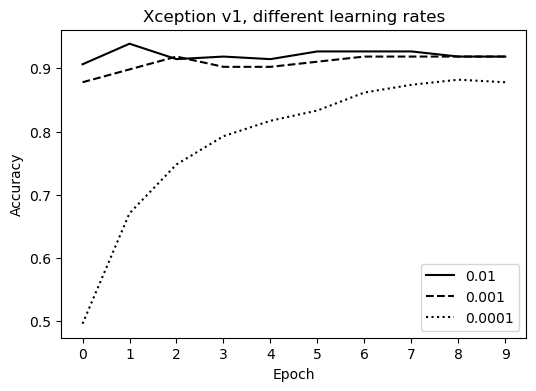

In [17]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, val_0_01, color='black', linestyle='solid', label='0.01')
plt.plot(epochs, val_0_001, color='black', linestyle='dashed', label='0.001')
plt.plot(epochs, val_0_0001, color='black', linestyle='dotted', label='0.0001')


plt.title('Xception v1, different learning rates')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()

plt.savefig('xception_v1_all_lr.svg')

plt.show()

In [18]:
model = make_model(learning_rate=0.001)


In [19]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_0_001 = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=callbacks)

Epoch 1/10
24/24 [==============================] - 5s 119ms/step - loss: 0.8096 - accuracy: 0.7089 - val_loss: 0.4212 - val_accuracy: 0.8618
Epoch 2/10
24/24 [==============================] - 2s 85ms/step - loss: 0.2597 - accuracy: 0.9266 - val_loss: 0.3171 - val_accuracy: 0.8862
Epoch 3/10
24/24 [==============================] - 2s 86ms/step - loss: 0.1723 - accuracy: 0.9559 - val_loss: 0.2644 - val_accuracy: 0.9065
Epoch 4/10
24/24 [==============================] - 2s 86ms/step - loss: 0.1286 - accuracy: 0.9733 - val_loss: 0.2378 - val_accuracy: 0.9106
Epoch 5/10
24/24 [==============================] - 2s 85ms/step - loss: 0.0989 - accuracy: 0.9893 - val_loss: 0.2243 - val_accuracy: 0.9187
Epoch 6/10
24/24 [==============================] - 2s 74ms/step - loss: 0.0805 - accuracy: 0.9947 - val_loss: 0.2108 - val_accuracy: 0.9146
Epoch 7/10
24/24 [==============================] - 2s 74ms/step - loss: 0.0657 - accuracy: 0.9947 - val_loss: 0.2153 - val_accuracy: 0.9065
Epoch 8/10
2

In [20]:
def make_model(learning_rate, droprate):
    base_model = Xception(
        weights='imagenet',
        input_shape=(150, 150, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))
    
    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)

    inner = keras.layers.Dense(100, activation='relu')(vector)
    drop = keras.layers.Dropout(droprate)(inner)

    outputs = keras.layers.Dense(number_of_categories)(drop)

    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    
    return model

In [21]:
model = make_model(learning_rate=0.001, droprate=0.0)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v2_0_0_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_0 = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks)

Epoch 1/30
24/24 [==============================] - 5s 118ms/step - loss: 0.5034 - accuracy: 0.8051 - val_loss: 0.3015 - val_accuracy: 0.8862
Epoch 2/30
24/24 [==============================] - 2s 87ms/step - loss: 0.1072 - accuracy: 0.9640 - val_loss: 0.2294 - val_accuracy: 0.9065
Epoch 3/30
24/24 [==============================] - 2s 86ms/step - loss: 0.0508 - accuracy: 0.9893 - val_loss: 0.1755 - val_accuracy: 0.9431
Epoch 4/30
24/24 [==============================] - 2s 75ms/step - loss: 0.0272 - accuracy: 0.9947 - val_loss: 0.2382 - val_accuracy: 0.9146
Epoch 5/30
24/24 [==============================] - 2s 74ms/step - loss: 0.0182 - accuracy: 0.9973 - val_loss: 0.2092 - val_accuracy: 0.9228
Epoch 6/30
24/24 [==============================] - 2s 75ms/step - loss: 0.0113 - accuracy: 0.9987 - val_loss: 0.2463 - val_accuracy: 0.9146
Epoch 7/30
24/24 [==============================] - 2s 76ms/step - loss: 0.0099 - accuracy: 0.9987 - val_loss: 0.1769 - val_accuracy: 0.9309
Epoch 8/30
2

In [22]:
model = make_model(learning_rate=0.001, droprate=0.2)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v2_0_2_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_1 = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks)

Epoch 1/30
24/24 [==============================] - 5s 119ms/step - loss: 0.5838 - accuracy: 0.7864 - val_loss: 0.2437 - val_accuracy: 0.9106
Epoch 2/30
24/24 [==============================] - 2s 87ms/step - loss: 0.1334 - accuracy: 0.9506 - val_loss: 0.2268 - val_accuracy: 0.9228
Epoch 3/30
24/24 [==============================] - 2s 88ms/step - loss: 0.0677 - accuracy: 0.9760 - val_loss: 0.1809 - val_accuracy: 0.9309
Epoch 4/30
24/24 [==============================] - 2s 76ms/step - loss: 0.0412 - accuracy: 0.9907 - val_loss: 0.2394 - val_accuracy: 0.9106
Epoch 5/30
24/24 [==============================] - 2s 76ms/step - loss: 0.0259 - accuracy: 0.9960 - val_loss: 0.2005 - val_accuracy: 0.9309
Epoch 6/30
24/24 [==============================] - 2s 89ms/step - loss: 0.0249 - accuracy: 0.9920 - val_loss: 0.2063 - val_accuracy: 0.9350
Epoch 7/30
24/24 [==============================] - 2s 76ms/step - loss: 0.0140 - accuracy: 0.9987 - val_loss: 0.1775 - val_accuracy: 0.9350
Epoch 8/30
2

In [23]:
model = make_model(learning_rate=0.001, droprate=0.5)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v2_0_5_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_2 = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks)

Epoch 1/30
24/24 [==============================] - 5s 123ms/step - loss: 0.7384 - accuracy: 0.7236 - val_loss: 0.3439 - val_accuracy: 0.8740
Epoch 2/30
24/24 [==============================] - 2s 89ms/step - loss: 0.2316 - accuracy: 0.9172 - val_loss: 0.2326 - val_accuracy: 0.9024
Epoch 3/30
24/24 [==============================] - 2s 89ms/step - loss: 0.1598 - accuracy: 0.9466 - val_loss: 0.2165 - val_accuracy: 0.9146
Epoch 4/30
24/24 [==============================] - 2s 89ms/step - loss: 0.1002 - accuracy: 0.9773 - val_loss: 0.1757 - val_accuracy: 0.9187
Epoch 5/30
24/24 [==============================] - 2s 76ms/step - loss: 0.0783 - accuracy: 0.9800 - val_loss: 0.2375 - val_accuracy: 0.9146
Epoch 6/30
24/24 [==============================] - 2s 77ms/step - loss: 0.0631 - accuracy: 0.9840 - val_loss: 0.1686 - val_accuracy: 0.9187
Epoch 7/30
24/24 [==============================] - 2s 88ms/step - loss: 0.0499 - accuracy: 0.9853 - val_loss: 0.1925 - val_accuracy: 0.9268
Epoch 8/30
2

In [24]:
model = make_model(learning_rate=0.001, droprate=0.8)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v2_0_8_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_3 = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks)

Epoch 1/30
24/24 [==============================] - 5s 121ms/step - loss: 1.2649 - accuracy: 0.5100 - val_loss: 0.5317 - val_accuracy: 0.8537
Epoch 2/30
24/24 [==============================] - 2s 88ms/step - loss: 0.6577 - accuracy: 0.7356 - val_loss: 0.3207 - val_accuracy: 0.8984
Epoch 3/30
24/24 [==============================] - 2s 89ms/step - loss: 0.5221 - accuracy: 0.8011 - val_loss: 0.2659 - val_accuracy: 0.9146
Epoch 4/30
24/24 [==============================] - 2s 79ms/step - loss: 0.4325 - accuracy: 0.8385 - val_loss: 0.2752 - val_accuracy: 0.8862
Epoch 5/30
24/24 [==============================] - 2s 90ms/step - loss: 0.4150 - accuracy: 0.8451 - val_loss: 0.2386 - val_accuracy: 0.9187
Epoch 6/30
24/24 [==============================] - 2s 76ms/step - loss: 0.3525 - accuracy: 0.8678 - val_loss: 0.2436 - val_accuracy: 0.9065
Epoch 7/30
24/24 [==============================] - 2s 77ms/step - loss: 0.3071 - accuracy: 0.8785 - val_loss: 0.2503 - val_accuracy: 0.8984
Epoch 8/30
2

In [25]:
epochs = history_0.epoch

train00 = history_0.history['accuracy']
train02 = history_1.history['accuracy']
train05 = history_2.history['accuracy']
train08 = history_3.history['accuracy']

val00 = history_0.history['val_accuracy']
val02 = history_1.history['val_accuracy']
val05 = history_2.history['val_accuracy']
val08 = history_3.history['val_accuracy']


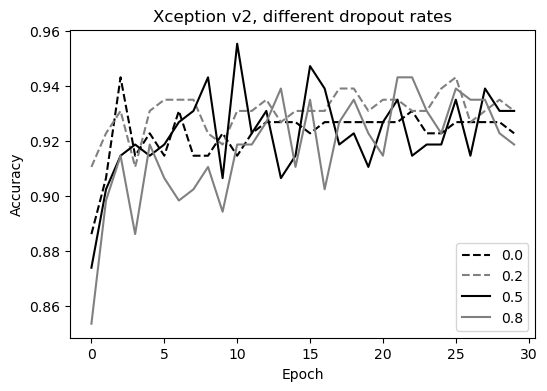

In [26]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, val00, color='black', linestyle='dashed', label='0.0')
plt.plot(epochs, val02, color='grey', linestyle='dashed', label='0.2')
plt.plot(epochs, val05, color='black', linestyle='solid', label='0.5')
plt.plot(epochs, val08, color='grey', linestyle='solid', label='0.8')


plt.title('Xception v2, different dropout rates')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.legend()

plt.savefig('xception_v2_dropout.svg')

plt.show()

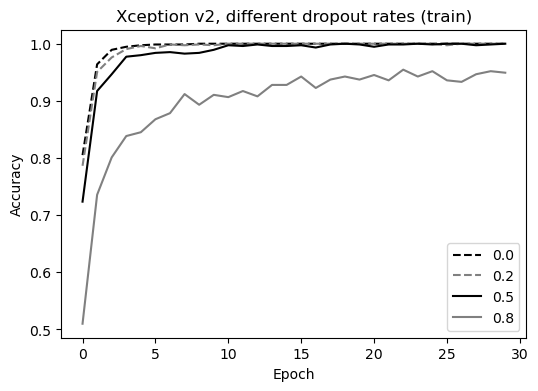

In [27]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, train00, color='black', linestyle='dashed', label='0.0')
plt.plot(epochs, train02, color='grey', linestyle='dashed', label='0.2')
plt.plot(epochs, train05, color='black', linestyle='solid', label='0.5')
plt.plot(epochs, train08, color='grey', linestyle='solid', label='0.8')


plt.title('Xception v2, different dropout rates (train)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.legend()

plt.savefig('xception_v2_dropout_train.svg')

plt.show()